# Calculating diversity and mutation

## Calculating mutational load
To calculate mutational load, the functions from `immcantation` suite's `shazam` [[Gupta2015]](https://academic.oup.com/bioinformatics/article/31/20/3356/195677) can be accessed via `rpy2` to work with the `dandelion` class object.

This can be run immediately after `pp.reassign_alleles` during the reannotation pre-processing stage because the required germline columns should be present in the genotyped `.tsv` file. I would recommend to run this after TIgGER [[Gadala-Maria2015]](https://www.pnas.org/content/112/8/E862), after the v_calls were corrected. Otherwise, if the reannotation was skipped, you can run it now as follows:

<b>Import modules</b>

In [1]:
import os
import dandelion as ddl

ddl.logging.print_header()

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import ann

dandelion==0.5.5.dev16 pandas==2.2.3 numpy==2.1.3 matplotlib==3.10.1 networkx==3.4.2 scipy==1.15.2


/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/nxviz/__init__.py:33: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)



In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser("~/Downloads/dandelion_tutorial/"))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc

sc.settings.verbosity = 3
import warnings

warnings.filterwarnings("ignore")
sc.logging.print_header()

scanpy==1.10.3 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.2 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


<b>Read in the previously saved files</b>

In [3]:
adata = sc.read_h5ad("adata.h5ad")
adata

AnnData object with n_obs × n_vars = 23715 × 1400
    obs: 'sampleid', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'has_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'umi_count_B_VDJ', 'umi_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain

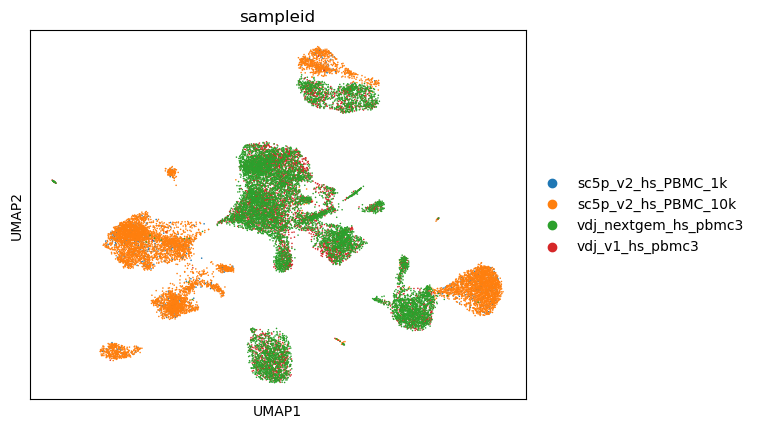

In [4]:
sc.pl.umap(adata, color="sampleid")

<div class="alert alert-info">

Note
    
This tutorial will be trying to quantify mutations in the BCR data, and this function requires access to IMGT-formatted VDJ gene calls with allelic information. So if you have ran `vdj.simplify` before this tutorial, then it would not work. Therefore, we are loading in the `Dandelion` object without simplified calls.

</div>

In [5]:
vdj = ddl.read_h5ddl("dandelion_results.h5ddl")
vdj

Dandelion class object with n_obs = 2112 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [6]:
# let's rerun the find_clone step again as it didn't get copied over
ddl.tl.find_clones(vdj)

Finding clonotypes


Finding clones based on B cell VJ chains : 100%|██████████| 209/209 [00:00<00:00, 6056.74it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 2238/2238 [00:00<00:00, 577297.19it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
 (0:00:00)


In [7]:
# let's recreate the vdj object with only the first two samples
subset_data = vdj.data[
    vdj.data["sample_id"].isin(["sc5p_v2_hs_PBMC_1k", "sc5p_v2_hs_PBMC_10k"])
]
subset_data

sequence_id  \
sequence_id                                                                                    
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1  sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2  sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1  sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1  sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2  sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2   
...                                                                                      ...   
sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACATGA_contig_2    sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACATGA_contig_2   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_1    sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_1   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_2    sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_2   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_1    sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_1   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_2    sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_2   

                                                                                        sequence  \
sequence_id                                                                                        
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1  TGGGGAGGAGTCAGTCCCAACCAGGACACGGCCTGGACATGAGGGT...   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2  ATCACATAACAACCACATTCCTCCTCTAAAGAAGCCCCTGGGAGCA...   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1  AGGAGTCAGACCCTGTCAGGACACAGCATAGACATGAGGGTCCCCG...   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1  ACTGTGGGGGTAAGAGGTTGTGTCCACCATGGCCTGGACTCCTCTC...   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2  GGGAGCATCACCCAGCAACCACATCTGTCCTCTAGAGAATCCCCTG...   
...                                                                                          ...   
sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACATGA_contig_2   AGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_1   AGGAGTCAGACCCTGTCAGGACACAGCATAGACATGAGGGTCCCCG...   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_2   CGAGCCCAGCACTGGAAGTCGCCGGTGTTTCCATTCGGTGATCATC...   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_1   GAGCTACAACAGGCAGGCAGGGGCAGCAAGATGGTGTTGCAGACCC...   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_2   TGGGGAGTGACTCCTGTGCCCCACCATGGACACACTTTGCTCCACG...   

                                              rev_comp productive  \
sequence_id                                                         
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1        F          T   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2        F          T   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1        F          T   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1        F          T   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2        F          T   
...                                                ...        ...   
sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACATGA_contig_2         F          T   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_1         F          T   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_2         F          T   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_1         F          T   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_2         F          T   

                                                                 v_call  \
sequence_id                                                               
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1  IGKV1-33*01,IGKV1D-33*01   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2  IGHV1-69*01,IGHV1-69D*01   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1                IGKV1-8*01   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1               IGLV5-45*02   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2                IGHV1-2*02   
...                                                                 ...   
sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACAT

In [8]:
# create a new Dandelion class with this subset
vdj2 = ddl.Dandelion(subset_data)
vdj2

Dandelion class object with n_obs = 794 and n_contigs = 2575
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', '

### `store_germline_reference`

We can store the corrected germline fasta files (after running TIgGER) in the `Dandelion` class as a dictionary.

In [9]:
# update the germline using the corrected files after tigger
vdj2.store_germline_reference(
    corrected="tutorial_scgp1/tutorial_scgp1_heavy_igblast_db-pass_genotype.fasta",
    germline=None,
    org="human",
)

Updating germline reference
 finished: Updated Dandelion object: 
   'germline', updated germline reference
 (0:00:00)


### `pp.create_germlines`

Then we run `pp.create_germline` to (re)create the `germline_alignment_d_mask` column in the data. This works by calling `CreateGermlines.py` with only `-d` and `-r` options. Add further arguments with `additional_args` like below for your needs. See https://changeo.readthedocs.io/en/stable/examples/germlines.html for more info.

<div class="alert alert-info">

Note
    
In order for this function to work, the V/D/J calls need to be in IMGT format with allelic information. So if you have ran `vdj.simplify` before this step, then it would not work.

</div>
    

In [10]:
ddl.pp.create_germlines(vdj2, additional_args=["--vf", "v_call_genotyped"])

Reconstructing germline sequences
Running command: CreateGermlines.py -d /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/tmp0hfo1zwm/tmp.tsv -r /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/tmp0hfo1zwm/germ.fasta --vf v_call_genotyped

     START> CreateGermlines
      FILE> tmp.tsv
GERM_TYPES> dmask
 SEQ_FIELD> sequence_alignment
   V_FIELD> v_call_genotyped
   D_FIELD> d_call
   J_FIELD> j_call
    CLONED> False

PROGRESS> 11:29:53 |####################| 100% (2,575) 0.0 min

 OUTPUT> tmp_germ-pass.tsv
RECORDS> 2575
   PASS> 2575
   FAIL> 0
    END> CreateGermlines

 finished: Returning Dandelion object: 
 (0:00:02)


Dandelion class object with n_obs = 794 and n_contigs = 2575
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start', 'c_sequence_end', 'c_score', 'c_identity', 'junction_aa_length', 'fwr1_aa', 'fwr2_aa', 'fwr3_aa', 'fwr4_aa', 'cdr1_aa', 'cdr2_aa', 'cdr3_a

Ensure that the `germline_alignment_d_mask` column is populated or subsequent steps will fail.

In [11]:
vdj2.data[["v_call_genotyped", "germline_alignment_d_mask"]]

v_call_genotyped  \
sequence_id                                                               
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1  IGKV1-33*01,IGKV1D-33*01   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2  IGHV1-69*01,IGHV1-69D*01   
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1                IGKV1-8*01   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1               IGLV5-45*02   
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2                IGHV1-2*02   
...                                                                 ...   
sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACATGA_contig_2   IGHV3-23*01,IGHV3-23D*01   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_1                 IGKV1-8*01   
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_2              IGHV3-30-3*01   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_1                 IGKV4-1*01   
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_2                 IGHV2-5*02   

                                                                       germline_alignment_d_mask  
sequence_id                                                                                       
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1  GACATCCAGATGACCCAGTCTCCATCCTCCCTGTCTGCATCTGTAG...  
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2  CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...  
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1  GCCATCCGGATGACCCAGTCTCCATCCTCATTCTCTGCATCTACAG...  
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1  CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...  
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2  CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...  
...                                                                                          ...  
sc5p_v2_hs_PBMC_1k_TTCCCAGAGTACATGA_contig_2   GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...  
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_1   GCCATCCGGATGACCCAGTCTCCATCCTCATTCTCTGCATCTACAG...  
sc5p_v2_hs_PBMC_1k_TTGAACGCAGGCTGAA_contig_2   CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...  
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_1   GACATCGTGATGACCCAGTCTCCAGACTCCCTGGCTGTGTCTCTGG...  
sc5p_v2_hs_PBMC_1k_TTGCCGTAGAATGTGT_contig_2   CAGATCACCTTGAAGGAGTCTGGTCCT...ACGCTGGTGAAACCCA...  

[2575 rows x 2 columns]

The default behaviour is to mask the D region with Ns with option.

### `pp.quantify_mutations`

The options for `pp.quantify_mutations` are the same as the basic mutational load analysis [vignette](https://shazam.readthedocs.io/en/version-0.1.8---mutation-profiling-enhancements/vignettes/Mutation-Vignette/) [[Gupta2015]](https://academic.oup.com/bioinformatics/article/31/20/3356/195677). The default behavior is to sum all mutations scores (heavy and light chains, silent and replacement mutations) for the same cell.

Again, this function can be run immediately after `pp.reassign_alleles` on the genotyped `.tsv` files (without loading into `pandas` or `Dandelion`). Here I'm illustrating a few other options that may be useful.

In [12]:
# switching back to using the full vdj object
ddl.pp.quantify_mutations(vdj)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
 (0:00:13)


In [13]:
ddl.pp.quantify_mutations(vdj, combine=False)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
 (0:00:07)


Specifying `split_locus = True` will split up the results for the different chains.

In [14]:
ddl.pp.quantify_mutations(vdj, split_locus=True)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
 (0:00:08)


To update the `AnnData` object, simply rerun `tl.transfer`.

In [15]:
ddl.tl.transfer(adata, vdj)

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.uns['clone_id']`
and `.obsp`
   'distances', clonotype-weighted adjacency matrix
   'connectivities', clonotype-weighted adjacency matrix (0:00:09)


In [16]:
adata

AnnData object with n_obs × n_vars = 23715 × 1400
    obs: 'sampleid', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'has_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'umi_count_B_VDJ', 'umi_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain

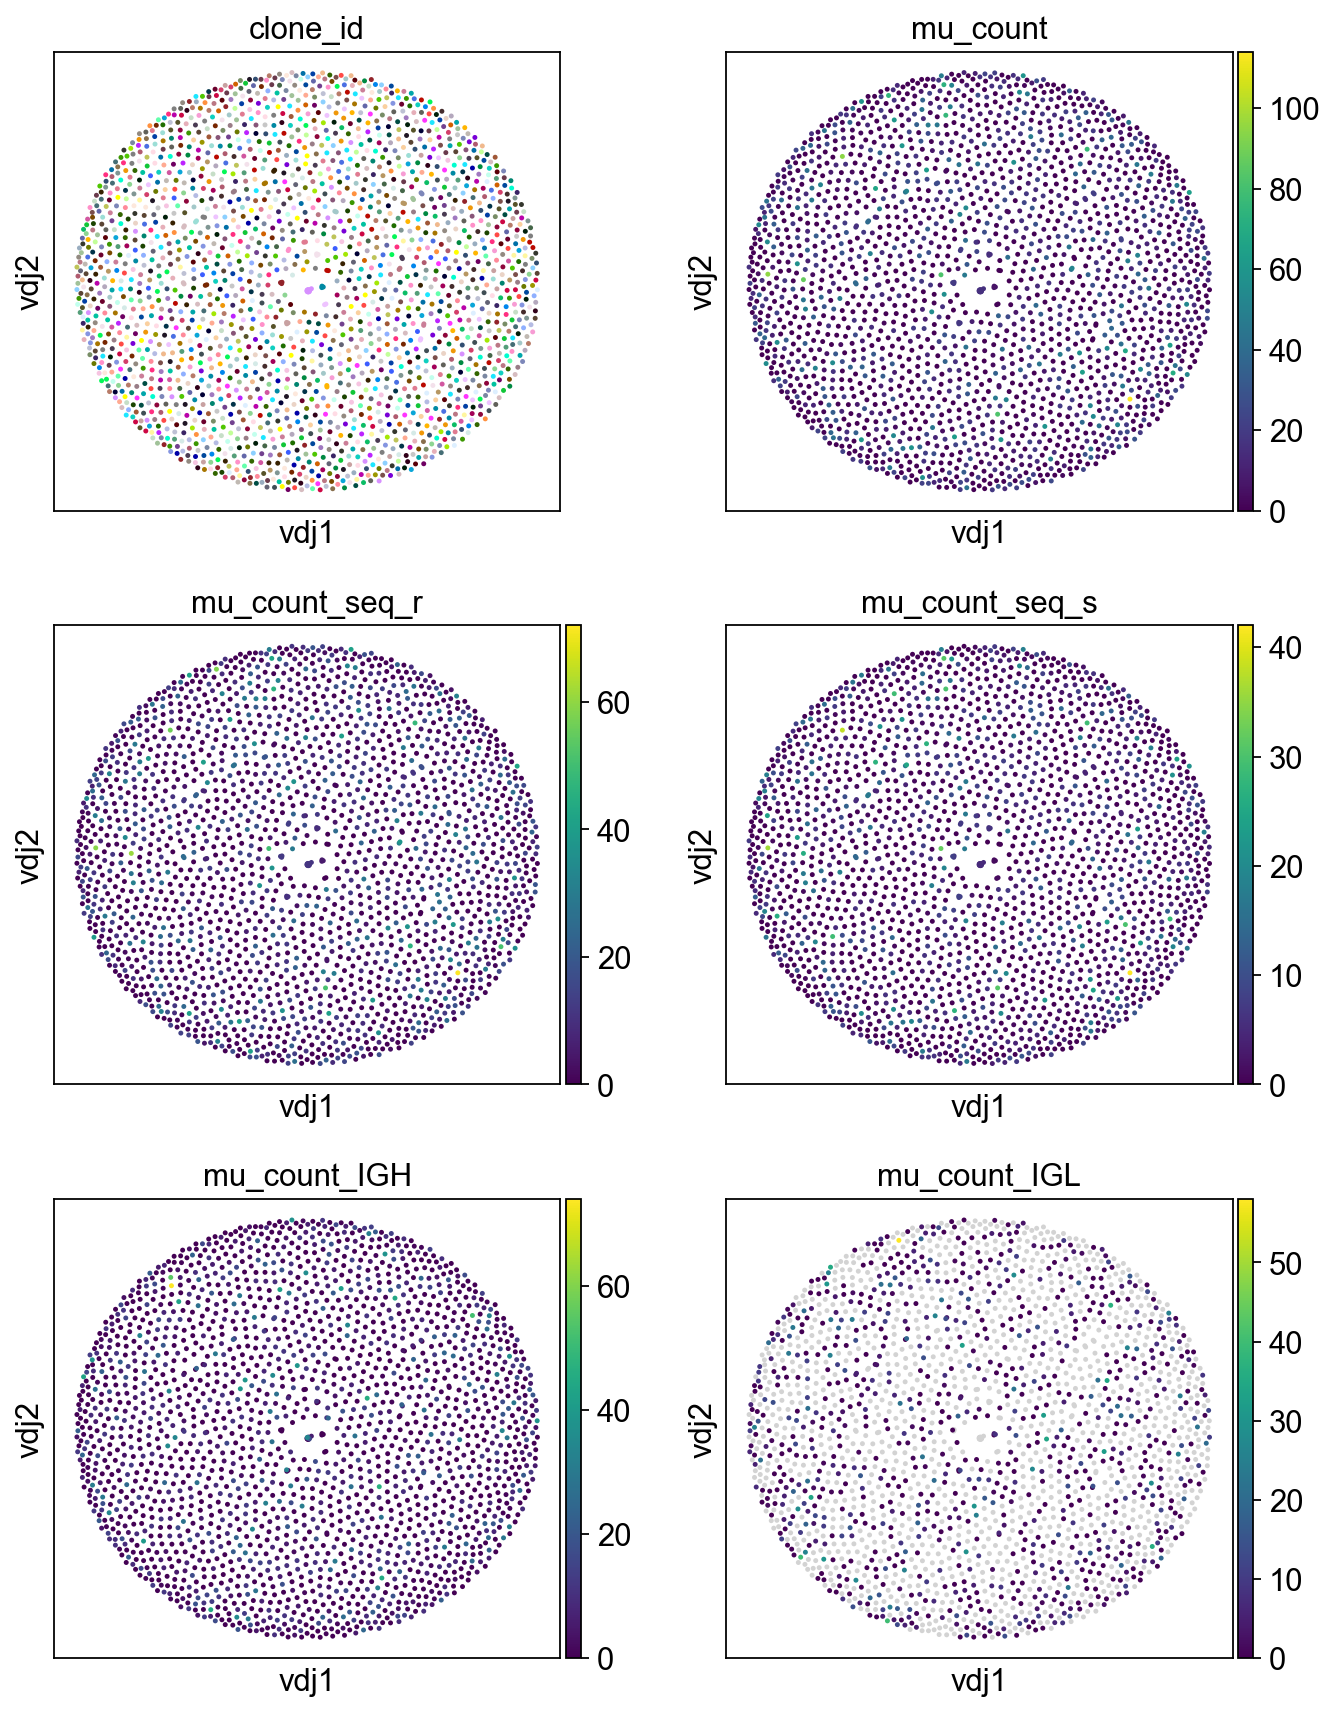

In [17]:
from scanpy.plotting.palettes import default_28, default_102

sc.set_figure_params(figsize=[4, 4])
ddl.pl.clone_network(
    adata,
    color=[
        "clone_id",
        "mu_count",
        "mu_count_seq_r",
        "mu_count_seq_s",
        "mu_count_IGH",
        "mu_count_IGL",
    ],
    ncols=2,
    legend_loc="none",
    legend_fontoutline=3,
    edges_width=1,
    palette=default_28 + default_102,
    color_map="viridis",
    size=20,
)

## Calculating diversity

*Disclaimer: the functions here are experimental. Please look to other sources/methods for doing this properly. Also, would appreciate any help to help me finalise this!* 

`tl.clone_rarefaction` and `pl.clone_rarefaction`

We can use `pl.clone_rarefaction` to generate rarefaction curves for the clones. `tl.clone_rarefaction` will populate the `.uns` slot with the results. `groupby` option must be specified. In this case, I decided to group by sample. The function will only work on an `AnnData` object and not a `Dandelion` object.

removing due to zero counts: 


Calculating rarefaction curve : 100%|██████████| 4/4 [00:00<00:00, 11.45it/s]


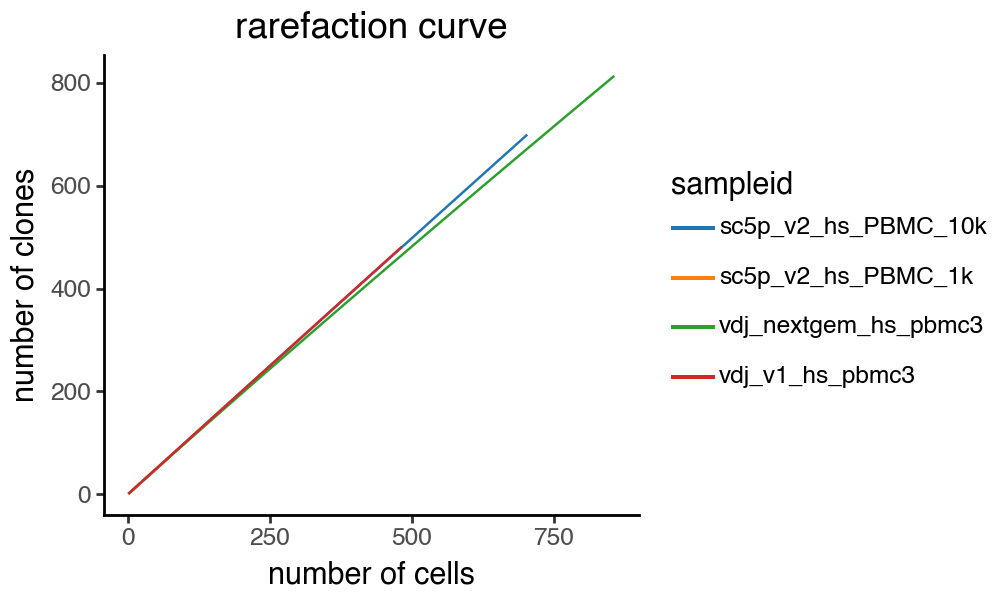

In [18]:
ddl.pl.clone_rarefaction(adata, color="sampleid")

### `ddl.tl.clone_diversity`

`tl.clone_diversity` allows for calculation of diversity measures such as <b>Chao1</b>, <b>Shannon Entropy</b> and <b>Gini indices</b>. 

While the function can work on both `AnnData` and `Dandelion` objects, the methods for gini index calculation will only work on a `Dandelion` object as it requires access to the network. 

For Gini indices, we provide several types of measures, inspired by bulk BCRseq analysis methods from [[Bashford-Rogers2013]](https://genome.cshlp.org/content/23/11/1874):

The following two indices are returned with `metric="clone_network"`.
   
   <b>I. network cluster/clone size Gini index</b> 
    
   In a contracted BCR network (where identical BCRs are collapsed into the same node/vertex), disparity in the distribution should be correlated to the amount of mutation events i.e. larger networks should indicate more mutation events and smaller networks should indicate lesser mutation events.

   <b>II. network vertex/node size Gini index</b>
    
   In the same contracted network, we can count the number of merged/contracted nodes; nodes with higher count numbers indicate more clonal expansion. Thus, disparity in the distribution of count numbers (referred to as vertex size) should be correlated to the overall clonality i.e. clones with larger vertex sizes are more monoclonal and clones with smaller vertex sizes are more polyclonal.
    
Therefore, a Gini index of 1 on either measures repesents perfect inequality (i.e. monoclonal and highly mutated) and a value of 0 represents perfect equality (i.e. polyclonal and unmutated).

<div class="alert alert-warning">

Note

However, there are a few limitations/challenges that comes with single-cell data: 

- <b>A.</b> In the process of contracting the network, we discard the single-cell level information. <br><br>

- <b>B.</b> Contraction of network is very slow, particularly when there is a lot of clonally-related cells. <br><br>

- <b>C.</b> For the full implementation and interpretation of both measures, although more evident with cluster/clone size, it requires the BCR repertoire to be reasonably/deeply sampled and we know that this is currently limited by the low recovery from single cell data with current technologies.

</div>

Therefore, we implement a few work around options, and 'experimental' options below, to try and circumvent these issues.

Firstly, as a work around for (C), the cluster size gini index can be calculated before or after network contraction. If performing before network contraction (default), it will be calculated based on the size of subgraphs of connected components in the main graph. This will retain the single-cell information and should appropriately show the distribution of the data. If performing after network contraction, the calculation is performed after network contraction, achieving the same effect as the method for bulk BCR-seq as described above. This option can be toggled by `use_contracted` and only applies to network cluster size gini index calculation.

   <b>III. clone centrality Gini index</b> - `metric="clone_centrality"`
   
   Node/vertex closeness centrality indicates how tightly packed clones are (more clonally related) and thus the distribution of the number of cells connected in each clone informs on whether clones in general are more monoclonal or polyclonal.

   <b>IV. clone degree Gini index</b> - `metric="clone_degree"`
   
   Node/vertex degree indicates how many cells are connected to an individual cell, another indication of how clonally related cells are. However, this would also highlight cells that are in the middle of large networks but are not necessarily within clonally expanded regions (e.g. intermediate connecting cells within the minimum spanning tree).
 
   <b>V. clone size Gini index</b> - `metric="clone_size"`
   
   This is not to be confused with the network cluster size gini index calculation above as this doesn't rely on the network, although the values should be similar. This is just a simple implementation based on the data frame for the relevant `clone_id` column. By default, this metric is also returned when running `metric=clone_centrality` or `metric=clone_degree`.

<div class="alert alert-warning">

Note

For (I) and (II), we can specify `expanded_only` option to compute the statistic for all clones or expanded only clones. Unlike options (I) and (II), the current calculation for (III) and (IV) is largely influenced by the amount of expanded clones i.e. clones with at least 2 cells, and not affected by the number of singleton clones because singleton clones will have a value of 0 regardless.
</div>

The diversity functions also have the option to perform downsampling to a fixed number of cells, or to the smallest sample size specified via `groupby` (default) so that sample sizes are even when comparing between groups.

if `return_table=True`, a data frame is returned; otherwise, the value gets added to the `AnnData.obs` or `Dandelion.metadata` accordingly.

In [19]:
sc.settings.verbosity = 1  # it gets very noisy
ddl.tl.clone_diversity(
    vdj, groupby="sample_id", method="gini", metric="clone_network"
)
ddl.tl.clone_diversity(
    vdj, groupby="sample_id", method="gini", metric="clone_centrality"
)
ddl.tl.transfer(adata, vdj)

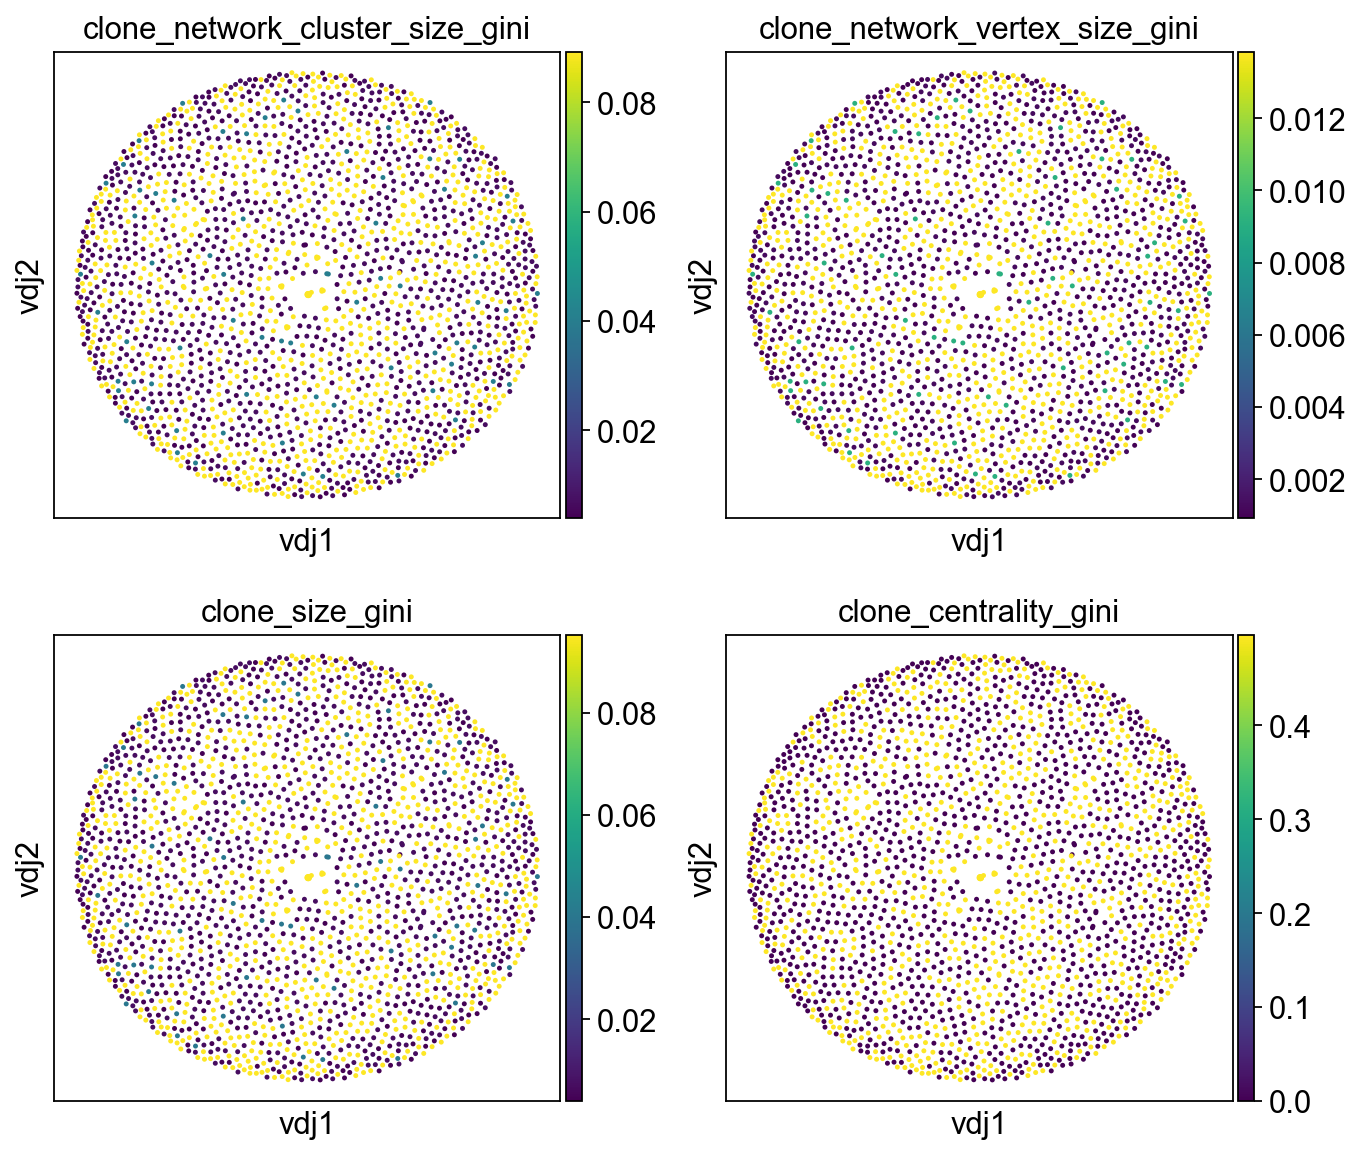

In [20]:
ddl.pl.clone_network(
    adata,
    color=[
        "clone_network_cluster_size_gini",
        "clone_network_vertex_size_gini",
        "clone_size_gini",
        "clone_centrality_gini",
    ],
    ncols=2,
    size=20,
)

With these particular samples, because there is not many expanded clones in general, the gini indices are quite low when calculated within each sample. We can re-run it by specifying `expanded_only = True` to only factor in expanded clones. We also specify the `key_added` option to create a new column instead of writing over the original columns.

In [21]:
ddl.tl.clone_diversity(
    vdj,
    groupby="sample_id",
    method="gini",
    metric="clone_network",
    expanded_only=True,
    key_added=[
        "clone_network_cluster_size_gini_expanded",
        "clone_network_vertex_size_gini_expanded",
    ],
)
ddl.tl.transfer(adata, vdj)

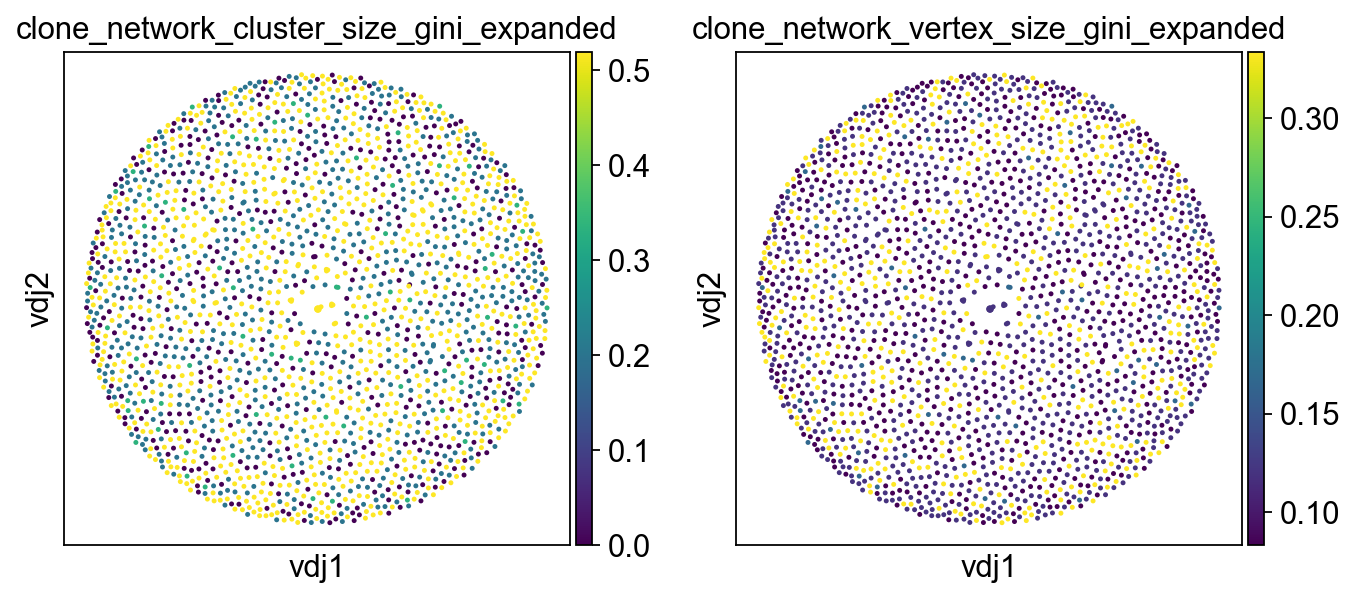

In [22]:
ddl.pl.clone_network(
    adata,
    color=[
        "clone_network_cluster_size_gini_expanded",
        "clone_network_vertex_size_gini_expanded",
    ],
    ncols=2,
    size=20,
)

We can also choose not to update the metadata to return a pandas dataframe.

In [23]:
gini = ddl.tl.clone_diversity(
    vdj, groupby="sample_id", method="gini", return_table=True
)
gini

clone_network_cluster_size_gini  \
sc5p_v2_hs_PBMC_10k                          0.006902   
sc5p_v2_hs_PBMC_1k                           0.040145   
vdj_v1_hs_pbmc3                              0.003976   
vdj_nextgem_hs_pbmc3                         0.089320   

                      clone_network_vertex_size_gini  
sc5p_v2_hs_PBMC_10k                         0.000925  
sc5p_v2_hs_PBMC_1k                          0.009132  
vdj_v1_hs_pbmc3                             0.001328  
vdj_nextgem_hs_pbmc3                        0.013850

In [24]:
gini2 = ddl.tl.clone_diversity(
    vdj,
    groupby="sample_id",
    method="gini",
    return_table=True,
    expanded_only=True,
    key_added=[
        "clone_network_cluster_size_gini_expanded",
        "clone_network_vertex_size_gini_expanded",
    ],
)
gini2

clone_network_cluster_size_gini_expanded  \
sc5p_v2_hs_PBMC_10k                                   0.200000   
sc5p_v2_hs_PBMC_1k                                    0.333333   
vdj_v1_hs_pbmc3                                       0.000000   
vdj_nextgem_hs_pbmc3                                  0.519054   

                      clone_network_vertex_size_gini_expanded  
sc5p_v2_hs_PBMC_10k                                  0.083333  
sc5p_v2_hs_PBMC_1k                                   0.166667  
vdj_v1_hs_pbmc3                                      0.333333  
vdj_nextgem_hs_pbmc3                                 0.119692

<Axes: xlabel='clone_network_cluster_size_gini', ylabel='clone_network_vertex_size_gini'>

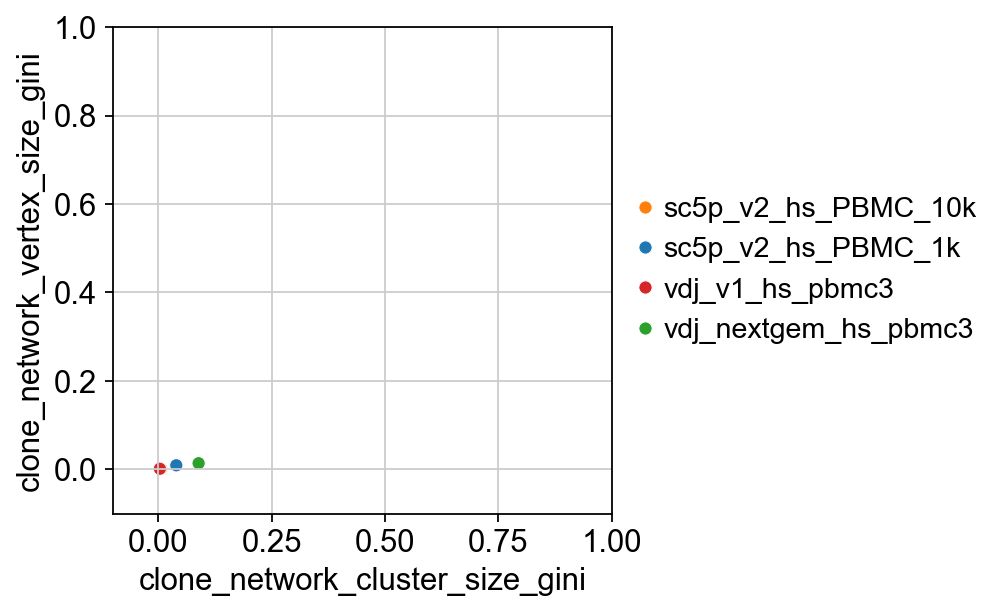

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

p = sns.scatterplot(
    x="clone_network_cluster_size_gini",
    y="clone_network_vertex_size_gini",
    data=gini,
    hue=gini.index,
    palette=dict(
        zip(adata.obs["sampleid"].cat.categories, adata.uns["sampleid_colors"])
    ),
)
p.set(ylim=(-0.1, 1), xlim=(-0.1, 1))
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)
p

<Axes: xlabel='clone_network_cluster_size_gini_expanded', ylabel='clone_network_vertex_size_gini_expanded'>

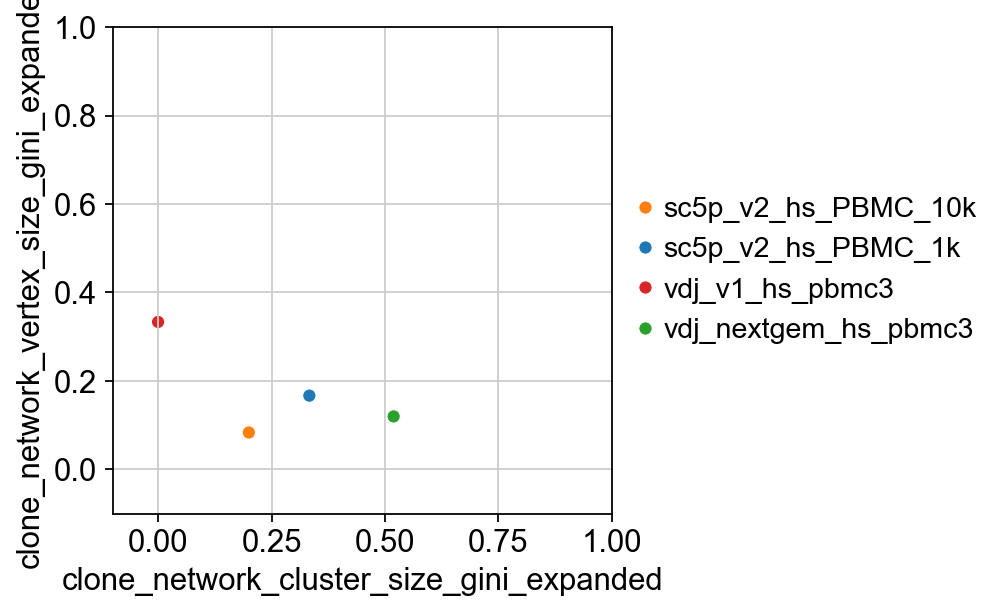

In [26]:
p2 = sns.scatterplot(
    x="clone_network_cluster_size_gini_expanded",
    y="clone_network_vertex_size_gini_expanded",
    data=gini2,
    hue=gini2.index,
    palette=dict(
        zip(adata.obs["sampleid"].cat.categories, adata.uns["sampleid_colors"])
    ),
)
p2.set(ylim=(-0.1, 1), xlim=(-0.1, 1))
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)
p2

We can also visualise what the results for the clone centrality gini indices.

In [27]:
gini = ddl.tl.clone_diversity(
    vdj,
    groupby="sample_id",
    method="gini",
    metric="clone_centrality",
    return_table=True,
)
gini

clone_size_gini  clone_centrality_gini
sc5p_v2_hs_PBMC_10k          0.006902               0.000000
sc5p_v2_hs_PBMC_1k           0.040145               0.000000
vdj_v1_hs_pbmc3              0.003976               0.000000
vdj_nextgem_hs_pbmc3         0.095265               0.496552

<Axes: xlabel='clone_size_gini', ylabel='clone_centrality_gini'>

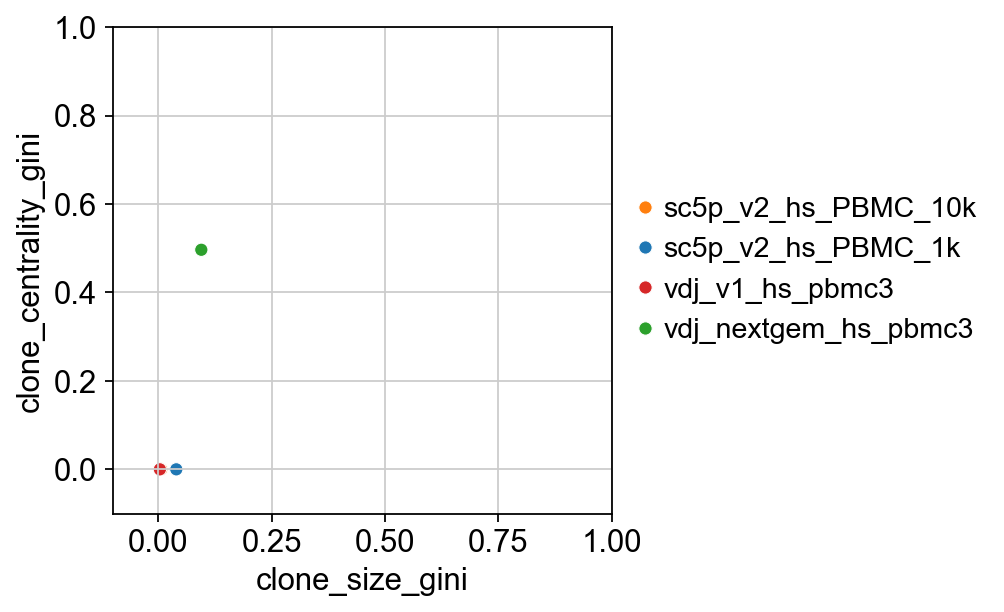

In [28]:
# not a great example because there's only 1 big clone in 1 sample.
p = sns.scatterplot(
    x="clone_size_gini",
    y="clone_centrality_gini",
    data=gini,
    hue=gini.index,
    palette=dict(
        zip(adata.obs["sampleid"].cat.categories, adata.uns["sampleid_colors"])
    ),
)
p.set(ylim=(-0.1, 1), xlim=(-0.1, 1))
plt.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)
p

Chao1 is an estimator based on abundance

In [29]:
ddl.tl.clone_diversity(
    vdj, groupby="sample_id", method="chao1", return_table=True
)

clone_size_chao1
sc5p_v2_hs_PBMC_10k       51482.600000
sc5p_v2_hs_PBMC_1k          853.000000
vdj_v1_hs_pbmc3           62876.000000
vdj_nextgem_hs_pbmc3      13798.538462

For Shannon Entropy, we can calculate a normalized (inspired by [scirpy's function](https://icbi-lab.github.io/scirpy/generated/scirpy.tl.alpha_diversity.html?highlight=diversity#scirpy.tl.alpha_diversity)) and non-normalized value.

In [30]:
ddl.tl.clone_diversity(
    vdj, groupby="sample_id", method="shannon", return_table=True
)

clone_size_normalized_shannon
sc5p_v2_hs_PBMC_10k                        0.999676
sc5p_v2_hs_PBMC_1k                         0.997607
vdj_v1_hs_pbmc3                            0.999877
vdj_nextgem_hs_pbmc3                       0.974769

In [31]:
ddl.tl.clone_diversity(
    vdj,
    groupby="sample_id",
    method="shannon",
    update_obs_meta=False,
    normalize=False,
)

That sums it up for now! Let me know if you have any ideas at [z.tuong@uq.edu.au] and I can try and see if i can implement it or we can work something out to collaborate on!